In [1]:
from torchvision.datasets.folder import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from statistics import mean
import impaintingLib as imp

import torchvision
from mpl_toolkits.axes_grid1 import ImageGrid
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Test with good mask/seg

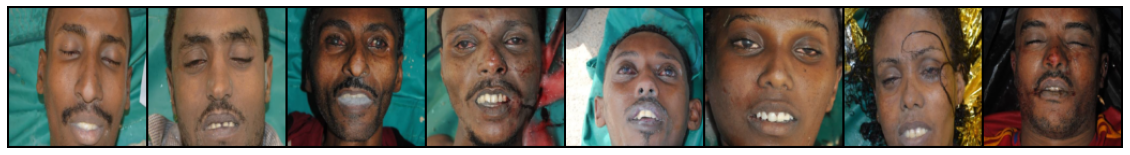

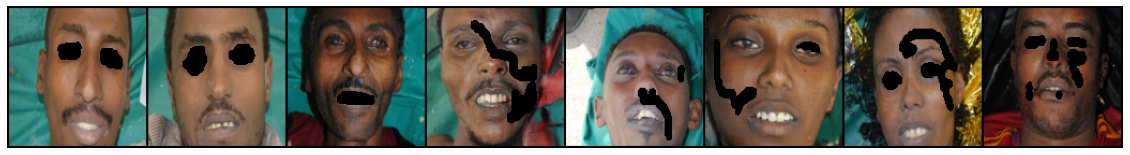

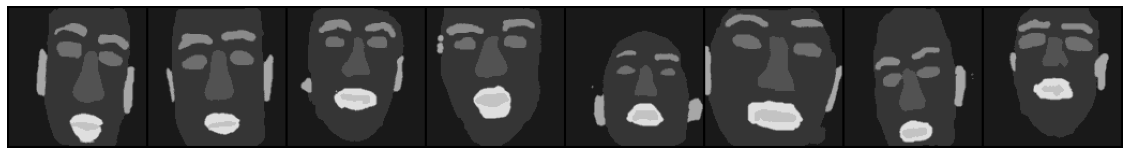

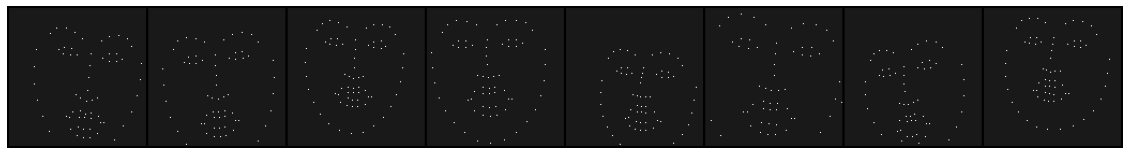

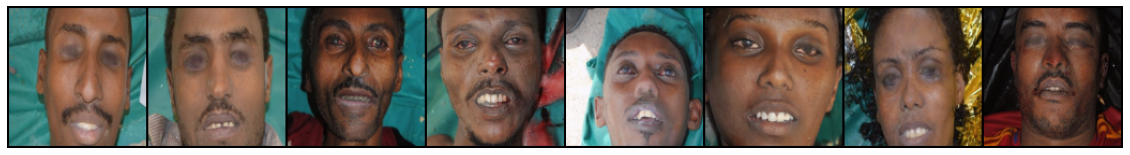

In [10]:
# Impainter
impainter = imp.model.UNet(5, netType="partial").to(device) 
impainter_weight_path = './modelSave/24_08/bigRun2115'
impainter.load_state_dict(torch.load(impainter_weight_path))
impainter.eval()

def testReal(impainter,base=True,altered=True,segmented=False,keypoints=False,predicted=True):
    image = imp.data.getTestImages("./data/test/real",factorResize=2).to(device)
    mask = imp.data.getTestImages("./data/test/mask",factorResize=2).to(device)
    segment  = imp.data.getTestImages("./data/test/seg",factorResize=2,doCrop=False).to(device)

    segment = torchvision.transforms.Grayscale()(segment)
    segment = segment * 255
    segment = (segment / 25) - 1
    segment = torch.round(segment)
    segment = (segment / 9) + 0.1

    mask = torchvision.transforms.Grayscale()(mask)
    n, c, h, w = image.shape
    x_prime = torch.empty((n, c, h, w), dtype=image.dtype, device=image.device)
    for i, (img, mask) in enumerate(zip(image, mask)):
        propag_img = img.clone()
        mask_bit = (mask > 0.5) * 1.
        for j,channel in enumerate(img[:3]) :
            propag_img[j] = channel * mask_bit
        x_prime[i] = propag_img

    x_prime2 = torch.cat((x_prime,segment),dim=1)
    keypointLayer = imp.components.getKeypoints(image)
    x_prime3 = torch.cat((x_prime2, keypointLayer),dim=1)

    with torch.no_grad():
        image_hat = impainter(x_prime3)
        image_hat = torch.clip(image_hat,0,1)
        image_hat = image_hat[:,:3]

    if base :
        imp.utils.plot_img(image)
    if altered : 
        imp.utils.plot_img(x_prime)
    if segmented : 
        imp.utils.plot_img(segment)
    if keypoints : 
        imp.utils.plot_img(keypointLayer)
    if predicted :
        imp.utils.plot_img(image_hat)
    
testReal(impainter,segmented=True,keypoints=True)

# Test datasets

In [2]:
tot_length = 0

image = imp.data.getTestImages("./data/utk",factorResize=2,doCrop=False,doShuffle=True)
length = len(imp.data.getTestData("./data/utk"))
tot_length += length
print(length)
#imp.utils.plot_img(image)

image = imp.data.getTestImages("./data/flickr",factorResize=2,doCrop=False,doShuffle=True)
length = len(imp.data.getTestData("./data/flickr"))
tot_length += length
print(length)
#imp.utils.plot_img(image)

image = imp.data.getTestImages("./data/lfw",factorResize=2,doShuffle=True)
length = len(imp.data.getTestData("./data/lfw"))
tot_length += length
print(length)
#imp.utils.plot_img(image)

image = imp.data.getTestImages("./data/celeba",factorResize=2,doShuffle=True)
length = len(imp.data.getTestData("./data/celeba"))
tot_length += length
print(length)
#imp.utils.plot_img(image)

print(tot_length)

9782
66534
13234
202599
292149


In [3]:
image = imp.data.randomTransfo(image)
#imp.utils.plot_img(image)

In [1]:
from torchvision.datasets.folder import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from statistics import mean
import impaintingLib as imp

import torchvision
from mpl_toolkits.axes_grid1 import ImageGrid
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
def allDataset():
    datasets = []
    datasets.append(imp.data.getDataset("./data/utk",factorResize=2,doShuffle=True,doCrop=False))
    datasets.append(imp.data.getDataset("./data/flickr",factorResize=2,doShuffle=True,doCrop=False))
    datasets.append(imp.data.getDataset("./data/lfw",factorResize=2,doShuffle=True))
    datasets.append(imp.data.getDataset("./data/celeba",factorResize=2,doShuffle=True))
    return torch.utils.data.ConcatDataset(datasets)

In [3]:
from torch.utils.tensorboard import SummaryWriter

def train_inpainting_segmented_keypoints(net, optimizer, loader, alter, runName="bigRun", scale_factor=4, epochs=5, simplify_seg=True, show_images=True):
    
    net.train()
    accum_iter = 100 
    lrs = []
    lambda1 = lambda epoch: 0.67 ** epoch
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)
    
    t1 = tqdm(range(epochs), desc=f"Training progress", colour="#00ff00")
    
    for epoch in t1:
        running_loss = []
        t2 = tqdm(loader, leave=False, colour="#005500") 

        for batch_idx,(x,_) in enumerate(t2):
            x = x.to(device)
            x = imp.data.randomTransfo(x)
            
            with torch.set_grad_enabled(True):
                segmented = imp.components.get_segmentation(x, simplify=simplify_seg, scale_factor=scale_factor)
                x_prime = alter(x)
                x_input = torch.cat((x_prime, segmented),dim=1)
                keypointLayer = imp.components.getKeypoints(x)
                x_input = torch.cat((x_input, keypointLayer),dim=1)

                outputs = net(x_input)

                loss = 0
                loss += torch.nn.L1Loss()(outputs, x)
                loss += imp.loss.perceptualVGG(outputs, x)
                loss += imp.loss.totalVariation(outputs, x)
                # loss += keypointLoss(outputs,x) * 200
                loss /= accum_iter

                running_loss.append(loss.item())
                loss.backward()

                if ((batch_idx + 1) % accum_iter == 0) or (batch_idx + 1 == len(t2)):
                    optimizer.step()
                    lrs.append(optimizer.param_groups[0]["lr"])
                    scheduler.step()
                    optimizer.zero_grad()
                t2.set_description(f'Epoch {epoch}, training loss: {mean(running_loss)}, epoch {epoch + 1}/{epochs}')
                
        t1.set_description(f'Epoch {epoch + 1}/{epochs}')
            
        if show_images:
            imp.utils.plot_img(x[:8])
            imp.utils.plot_img(x_prime[:8])
            imp.utils.plot_img(segmented[:8])
            imp.utils.plot_img(torch.clip(outputs[:8], 0, 1))
            imp.utils.plot_img(keypointLayer[:8])
            
        writer = SummaryWriter("runs/" + runName)
        writer.add_scalar("training loss", mean(running_loss), epoch)
        writer.add_image("Original",make_grid(x[:8]))
        writer.add_image("Predict",make_grid(torch.clip(outputs[:8], 0, 1)))
        writer.close()
        
        torch.save(net.state_dict(),"./modelSave/14_09/{}_{}".format(runName,epoch))# Gros entrainement

In [ ]:
factorResize = 2
scale_factor = 2
batch_size=16
runName = "bestMore"

model = imp.model.UNet(5, netType="partial").to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=0.001)
alter = imp.mask.Alter(resize=factorResize,seed=0,test=True).irregularMask # squareMask irregularMask

dataset = allDataset()
print(len(dataset),dataset)
#dataset,_ = torch.utils.data.random_split(dataset, [1000, len(dataset)-1000])
#print(len(dataset),dataset)
trainloader = DataLoader(dataset, num_workers=2, batch_size=16, shuffle=True)
print(len(trainloader),trainloader)

model.load_state_dict(torch.load("./modelSave/24_08/bigRun2115"))
train_inpainting_segmented_keypoints(model, optimizer, trainloader, alter, runName=runName, scale_factor=scale_factor, simplify_seg=True, epochs=30)
torch.save(model.state_dict(),"./modelSave/14_09/" + runName)

292149 <torch.utils.data.dataset.ConcatDataset object at 0x7f161e9ee970>
18260 <torch.utils.data.dataloader.DataLoader object at 0x7f161e9eea00>


Training progress:   0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/18260 [00:00<?, ?it/s]